### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import random
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Input, Dense, Activation, Dropout, Bidirectional
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2024-08-14 02:50:54.634904: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 02:50:54.634973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 02:50:54.636710: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data

In [3]:
data = pd.read_csv('/kaggle/input/btc-ohlc/BTC_OHLC.csv')
data = data[data['Datetime'] <= '2023-12-31']
data['Log Close'] = np.log(data['Close'])

In [4]:
def create_dataset(dataset, time_step=30):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(data['Log Close']).reshape(-1, 1))

time_step = 30
X, Y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into train and test sets
train_size = int(len(X) * 0.6975)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

### Model

In [6]:
# Build the LSTM model
model = Sequential()

# Input Layer
model.add(Input(shape=(time_step, 1)))

# First LSTM layer
model.add(LSTM(64, return_sequences=True))
model.add(Activation('relu'))

# Second LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(Activation('relu'))

# Third LSTM layer
model.add(LSTM(128))
model.add(Activation('relu'))

# Hidden Dense layer with 128 neurons
model.add(Dense(128))
model.add(Activation('relu'))

# Second hidden Dense layer with 64 neurons
model.add(Dense(64))

# Output layer
model.add(Dense(1))

In [7]:
adam = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=adam)

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, min_lr=1e-6)

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,129 (1.04 MB)

 Trainable params: 272,129 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
model.fit(X_train, Y_train, epochs=1000, validation_split=0.2, batch_size=64, verbose=1,callbacks=[early_stopping])

Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0683 - val_loss: 0.0030
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015 - val_loss: 6.3497e-04
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6166e-04 - val_loss: 4.9101e-04
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8138e-04 - val_loss: 5.3748e-04
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7240e-04 - val_loss: 6.9311e-04
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7227e-04 - val_loss: 5.5222e-04
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4333e-04 - val_loss: 6.3874e-04
Epoch 8/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7793e-04 - val_loss: 3.8791e-04
Epoch 9/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4652e-04 - val_loss: 3.9248e-04
Epoch 10/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2849e-04 - val_loss: 0.0010
Epoch 11/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.0

In [10]:
# Evaluate the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict).flatten()
test_predict = scaler.inverse_transform(test_predict).flatten()

Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [11]:
# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(np.exp(Y_train), np.exp(train_predict)))
test_rmse = np.sqrt(mean_squared_error(np.exp(Y_test), np.exp(test_predict)))

# Calculate MAPE
train_mape = mean_absolute_percentage_error(np.exp(Y_train), np.exp(train_predict))
test_mape = mean_absolute_percentage_error(np.exp(Y_test), np.exp(test_predict))

In [12]:
train_rmse, test_rmse, train_mape, test_mape

(288.20723299463657,
 1377.7430762937863,
 0.03018556235516121,
 0.02463649941021719)

### Construct Portfolio Based on Prediction

Predict the close price of (2021-01-01 to 2023-12-31) for its position at the closing of (2020-12-31 to 2023-12-30)

In [13]:
np.exp(Y_train[-1])

array([28992.79])

In [14]:
data[data['Datetime'] == '2020-12-31']

,Datetime,Open,High,Low,Close,Volume,Log Close
2553,2020-12-31,28893.21,29300.0,27930.75,28992.79,9477.676618,10.274802


In [15]:
y_pred, y_true = np.exp(test_predict), np.exp(Y_test.flatten())

# Insert True Previous Value
y_true = np.insert(y_true, 0, np.exp(Y_train[-1]))

In [16]:
prediction = (y_pred > y_true[:-1]).astype(int)
real = (y_true[1:] > y_true[:-1]).astype(int)

In [17]:
position1 = np.where(prediction == 0, -1, prediction)
curr = position1[0]
position2 = [curr]
for i in range(1, len(position1)):
    if curr == 0 or curr == position1[i]:
        curr = position1[i]
    else:
        curr = 0
    position2.append(curr)

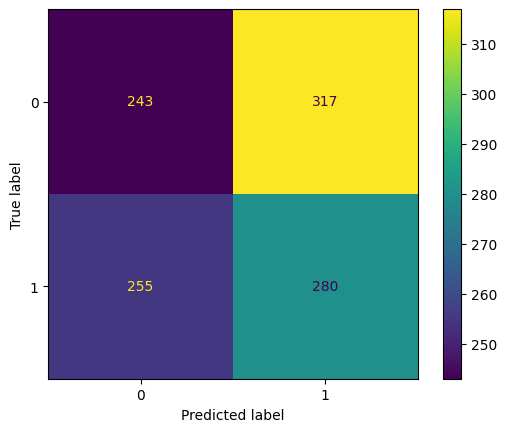

In [18]:
conf_matrix = confusion_matrix(real, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

In [19]:
accuracy = accuracy_score(real, prediction)
accuracy

0.4776255707762557

y_true is the close price from 2020-12-31 to 2023-12-31, y_pred is the prediction close price of 2021-01-01 to 2023-12-31

In [20]:
np.array(position2)[:20]

array([ 1,  0,  1,  1,  0,  1,  1,  1,  1,  0, -1, -1, -1,  0,  1,  0, -1,
       -1,  0, -1])

In [21]:
y_true[:20]

array([28992.79, 29402.64, 32216.53, 33097.83, 32005.88, 34039.05,
       36849.94, 39510.49, 40667.07, 40239.06, 38173.73, 35455.58,
       34035.02, 37393.49, 39134.35, 36756.57, 36000.  , 35819.25,
       36616.95, 35917.62])

In [22]:
val = 1
portf = [1]
for i in range(1, len(y_true)):
    val = val * (1 + position2[i-1] * (y_true[i] - y_true[i-1]) / y_true[i-1])
    portf.append(val)

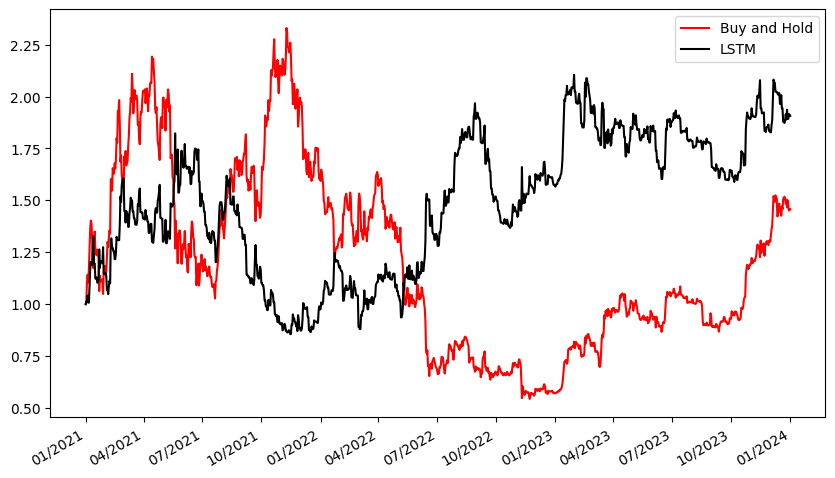

In [23]:
buy_and_hold = y_true / y_true[0]
dates = pd.date_range(start='2021-01-01', end='2024-01-01', freq='D')

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(dates, buy_and_hold, color='red', label='Buy and Hold')
plt.plot(dates, portf, color='black', label='LSTM')

# Set major formatter and locator for the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

# Add a legend
plt.legend()

# Automatically format x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Show the plot
plt.show()